<a href="https://colab.research.google.com/github/caiogasparine/SCS_3253_061-Machine-Learning/blob/main/Toronto_Police_Major_Crime_Indicators_MCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Source of Data: Major Crime Indicators (MCI) Historical**

This dataset includes all Major Crime Indicators (MCI) occurrences by reported date and related offences from 2014 to June 30, 2022.

https://data.torontopolice.on.ca/pages/major-crime-indicators


# 1 - Big Picture / Frame the problem 
University of Toronto
SCS 3253-061 - Machine Learning // Instructor: Saeid Abolfazli

**Group Members:**
*   Caio Gasparine
*   Fabio Queiroz
*   Olivier Sangam
*   Illidan Yuan

# 2 - Get the data / Develop the pipeline

Data profiling was done to ensure data quality and integrity. Contents of each field were analyzed for any anomalies and Null values. None we found.

In [1]:
### Toronto Police / MCI indicators
### Created on February 18, 2023 / Last update March 21, 2023
### Important assumptions: occurrenceyear will be used to base all the statistics and evaluations (reportedyear)
### This is to reflect WHEN the event really happened 

### Loading the main used libraries
from datetime import date
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings                    #These 2 lines remove all the warnigns in the code  
warnings.filterwarnings("ignore")  #These 2 lines remove all the warnigns in the code  
%matplotlib inline
from pandas.plotting import scatter_matrix
from google.colab import drive

from google.colab import data_table        #Mar 16, 2023 - Interactive Tables for DataFrames 
data_table.enable_dataframe_formatter()    #Mar 16, 2023 - Interactive Tables for Dataframes 

In [2]:
### Change the code here, depending on your dataset location
### data = pd.read_csv('Major_Crime_Indicators.csv', header=0)
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Major_Crime_Indicators.csv', header=0)

Mounted at /content/drive


# 3 - Explore and visualize the data to gain insights


In [3]:
### Exploring the data to gain insigths // (lines, colunms) OR (instances, features) 
data.shape

(301233, 30)

In [4]:
### Exploring the data to gain insigths // visualizing all the columns available 
data.columns

Index(['X', 'Y', 'Index_', 'event_unique_id', 'Division', 'occurrencedate',
       'reporteddate', 'location_type', 'premises_type', 'ucr_code', 'ucr_ext',
       'offence', 'reportedyear', 'reportedmonth', 'reportedday',
       'reporteddayofyear', 'reporteddayofweek', 'reportedhour',
       'occurrenceyear', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour',
       'mci_category', 'Hood_ID', 'Neighbourhood', 'Longitude', 'Latitude',
       'ObjectId'],
      dtype='object')

In [5]:
### Exploring the data to gain insigths // visualizing the data - 5 first instances
data.head(5)

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,...,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
0,-8.850398e+06,5.429359e+06,201,GO-20141273318,D31,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Apartment (Rooming House, Condo)",Apartment,1430,...,3.0,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371,1
1,-8.818405e+06,5.436836e+06,202,GO-20141274349,D42,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,...,3.0,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861,2
2,-8.853791e+06,5.402071e+06,203,GO-20141274052,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,...,3.0,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085,3
3,-8.832822e+06,5.419628e+06,204,GO-20141276966,D53,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,...,3.0,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212,4
4,-8.853452e+06,5.410706e+06,205,GO-20141274457,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Convenience Stores,Commercial,1610,...,3.0,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247,5


In [6]:
### Exploring the data to gain insigths // visualizing the data - 5 last instances
data.tail(5)

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,...,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
301228,-8.844901e+06,5.433057e+06,301113,GO-20221234233,D32,2022/06/28 04:00:00+00,2022/06/29 04:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2135,...,28.0,179.0,Tuesday,20,Auto Theft,35,Westminster-Branson,-79.455098,43.790363,301229
301229,-8.820395e+06,5.430803e+06,301114,GO-20221234061,D43,2022/06/28 04:00:00+00,2022/06/29 04:00:00+00,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2135,...,28.0,179.0,Tuesday,21,Auto Theft,137,Woburn,-79.234954,43.775740,301230
301230,-8.825525e+06,5.429271e+06,301115,GO-20221234664,D41,2022/05/20 04:00:00+00,2022/06/29 04:00:00+00,Other Commercial / Corporate Places (For Profi...,Commercial,2135,...,20.0,140.0,Friday,12,Auto Theft,126,Dorset Park,-79.281037,43.765801,301231
301231,0.000000e+00,0.000000e+00,301116,GO-20221235156,D41,2022/06/29 04:00:00+00,2022/06/29 04:00:00+00,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2135,...,29.0,180.0,Wednesday,0,Auto Theft,NSA,NSA,0.000000,0.000000,301232
301232,-8.854585e+06,5.426966e+06,301117,GO-20221236298,D31,2022/06/29 04:00:00+00,2022/06/29 04:00:00+00,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2135,...,29.0,180.0,Wednesday,16,Auto Theft,22,Humbermede,-79.542092,43.750849,301233


In [7]:
### Exploring the data to gain insigths // additional infor about your data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301233 entries, 0 to 301232
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    301233 non-null  float64
 1   Y                    301233 non-null  float64
 2   Index_               301233 non-null  int64  
 3   event_unique_id      301233 non-null  object 
 4   Division             301233 non-null  object 
 5   occurrencedate       301233 non-null  object 
 6   reporteddate         301233 non-null  object 
 7   location_type        301233 non-null  object 
 8   premises_type        301233 non-null  object 
 9   ucr_code             301233 non-null  int64  
 10  ucr_ext              301233 non-null  int64  
 11  offence              301233 non-null  object 
 12  reportedyear         301233 non-null  int64  
 13  reportedmonth        301233 non-null  object 
 14  reportedday          301233 non-null  int64  
 15  reporteddayofyear

In [8]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['mci_category'].value_counts()

Assault            161833
Break and Enter     59440
Auto Theft          40794
Robbery             29230
Theft Over           9936
Name: mci_category, dtype: int64

In [9]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['location_type'].value_counts()

Apartment (Rooming House, Condo)                                          72061
Single Home, House (Attach Garage, Cottage, Mobile)                       54076
Streets, Roads, Highways (Bicycle Path, Private Road)                     47619
Other Commercial / Corporate Places (For Profit, Warehouse, Corp. Bldg    34774
Parking Lots (Apt., Commercial Or Non-Commercial)                         25322
Bar / Restaurant                                                          12031
Open Areas (Lakes, Parks, Rivers)                                          6278
Schools During Supervised Activity                                         4567
Convenience Stores                                                         3851
Ttc Subway Station                                                         3648
Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)          3454
Private Property Structure (Pool, Shed, Detached Garage)                   2743
Hospital / Institutions / Medical Facili

In [10]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['ucr_code'].value_counts()

1430    110901
2120     59416
2135     40794
1420     34218
1610     29229
2130      7018
1460      5282
1480      3486
1450      3471
1410      2502
2132      2423
1457      1089
1461       559
2133       495
1455       180
1470       106
1462        23
1440        14
2125        13
2121        11
1475         2
1611         1
Name: ucr_code, dtype: int64

In [11]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['premises_type'].value_counts()

Outside        80079
Apartment      72061
Commercial     60860
House          54076
Other          17788
Transit         8603
Educational     7766
Name: premises_type, dtype: int64

In [12]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['offence'].value_counts()

Assault                           110528
B&E                                50182
Theft Of Motor Vehicle             40794
Assault With Weapon                27191
Robbery - Mugging                   8393
B&E W'Intent                        7311
Assault Bodily Harm                 7027
Theft Over                          5532
Assault Peace Officer               5174
Robbery - Other                     4857
Robbery With Weapon                 4798
Robbery - Business                  4343
Assault - Resist/ Prevent Seiz      3018
Aggravated Assault                  2483
Theft From Motor Vehicle Over       2423
Robbery - Swarming                  2289
Discharge Firearm With Intent       2003
Unlawfully In Dwelling-House        1821
Discharge Firearm - Recklessly      1441
Theft From Mail / Bag / Key         1197
Robbery - Home Invasion             1132
Pointing A Firearm                  1089
Robbery - Purse Snatch              1039
Robbery - Financial Institute        891
Robbery - Vehicl

In [13]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['Neighbourhood'].value_counts()

Waterfront Communities-The Island    11302
Church-Yonge Corridor                 9942
Bay Street Corridor                   8530
West Humber-Clairville                8103
Moss Park                             7287
                                     ...  
Yonge-St.Clair                         596
Guildwood                              559
Maple Leaf                             550
Woodbine-Lumsden                       549
Lambton Baby Point                     472
Name: Neighbourhood, Length: 141, dtype: int64

In [14]:
### Exploring the data to gain insigths // Descriptive statistics that summarizes the central tendency, dispersion and shape 
### of a dataset’s distribution, excluding NaN values for all columns/features
data.describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Longitude,Latitude,ObjectId
count,3.012330e+05,3.012330e+05,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301133.000000,301133.000000,301133.000000,301233.000000,301233.000000,301233.000000,301233.000000
mean,-8.724562e+06,5.350375e+06,150617.000000,1702.422928,146.565585,2017.876713,15.736659,180.765756,12.808786,2017.822852,15.456476,180.544766,12.601591,-78.374071,43.143874,150617.000000
std,9.966746e+05,6.112283e+05,86958.621157,326.260102,51.988967,2.436940,8.766766,103.717225,6.502562,2.475716,8.914754,104.141362,7.243753,8.953280,4.928613,86958.621157
min,-8.910331e+06,0.000000e+00,1.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,-80.042866,0.000000,1.000000
25%,-8.846681e+06,5.412946e+06,75309.000000,1430.000000,100.000000,2016.000000,8.000000,92.000000,8.000000,2016.000000,8.000000,92.000000,7.000000,-79.471086,43.659806,75309.000000
50%,-8.838015e+06,5.419000e+06,150617.000000,1450.000000,100.000000,2018.000000,16.000000,178.000000,13.000000,2018.000000,15.000000,178.000000,14.000000,-79.393238,43.699132,150617.000000
75%,-8.829868e+06,5.426986e+06,225925.000000,2120.000000,200.000000,2020.000000,23.000000,270.000000,18.000000,2020.000000,23.000000,270.000000,19.000000,-79.320056,43.750978,225925.000000
max,0.000000e+00,5.517228e+06,301233.000000,2135.000000,230.000000,2022.000000,31.000000,366.000000,23.000000,2022.000000,31.000000,366.000000,23.000000,0.000000,44.333691,301233.000000


In [15]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['occurrenceyear'].value_counts()

2019.0    39967
2018.0    37440
2017.0    35501
2020.0    34973
2021.0    34277
2016.0    33608
2015.0    32920
2014.0    32467
2022.0    18675
2013.0      596
2012.0      186
2011.0      130
2010.0       96
2009.0       73
2008.0       47
2007.0       34
2004.0       27
2000.0       26
2005.0       25
2001.0       21
2002.0       17
2003.0       15
2006.0       12
Name: occurrenceyear, dtype: int64

In [16]:
### Exploring the data to gain insigths
### Defining our scope with years with complete data 2014 to 2021 // March 7, 2023

### ocurrencedate min = 9/6/1966 and year = NULL AND ocurrencedata max = 30/06/2022
### Clearning the dataset to have the full data for a complete year

data = data[data.occurrenceyear >=2014]
data = data[data.occurrenceyear <=2021]

In [17]:
### Exploring the data to gain insigths / Check if any column has missing values ("False" = not missing - "True" = missing)
data.isnull().any()

X                      False
Y                      False
Index_                 False
event_unique_id        False
Division               False
occurrencedate         False
reporteddate           False
location_type          False
premises_type          False
ucr_code               False
ucr_ext                False
offence                False
reportedyear           False
reportedmonth          False
reportedday            False
reporteddayofyear      False
reporteddayofweek      False
reportedhour           False
occurrenceyear         False
occurrencemonth        False
occurrenceday          False
occurrencedayofyear    False
occurrencedayofweek    False
occurrencehour         False
mci_category           False
Hood_ID                False
Neighbourhood          False
Longitude              False
Latitude               False
ObjectId               False
dtype: bool

In [18]:
### Exploring the data to gain insigths / Visualizing data from specfic columns/features
data[['mci_category','offence','ucr_ext']]

,mci_category,offence,ucr_ext
0,Assault,Assault,100
1,Break and Enter,B&E,200
2,Assault,Assault,100
3,Theft Over,Theft Over,210
4,Robbery,Robbery - Business,210
...,...,...,...
301181,Assault,Assault,100
301183,Assault,Assault,100
301193,Assault,Assault,100
301201,Break and Enter,B&E,200


In [19]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data["mci_category"].value_counts()

Assault            151290
Break and Enter     56446
Auto Theft          36415
Robbery             27786
Theft Over           9216
Name: mci_category, dtype: int64

In [20]:
### Exploring the data to gain insigths // Descriptive statistics that summarizes the central tendency, dispersion and shape 
### of a dataset’s distribution, excluding NaN values for selected columns/features
data[0:-1].describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Longitude,Latitude,ObjectId
count,2.811520e+05,2.811520e+05,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000
mean,-8.725778e+06,5.351167e+06,141581.349932,1700.833784,146.402743,2017.611783,15.747059,186.499072,12.826980,2017.578150,15.492637,186.285347,12.618488,-78.385001,43.150236,141581.726422
std,9.911736e+05,6.078600e+05,81452.205268,325.535828,51.918008,2.261660,8.767522,103.893110,6.519573,2.250528,8.904283,104.130965,7.232712,8.903864,4.901449,81452.770560
min,-8.910331e+06,0.000000e+00,2.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2014.000000,1.000000,1.000000,0.000000,-80.042866,0.000000,1.000000
25%,-8.846627e+06,5.412955e+06,71136.750000,1430.000000,100.000000,2016.000000,8.000000,98.000000,8.000000,2016.000000,8.000000,98.000000,7.000000,-79.470606,43.659859,71136.750000
50%,-8.837968e+06,5.419022e+06,141569.500000,1450.000000,100.000000,2018.000000,16.000000,189.000000,13.000000,2018.000000,16.000000,189.000000,14.000000,-79.392819,43.699278,141566.500000
75%,-8.829773e+06,5.426993e+06,212066.250000,2120.000000,200.000000,2020.000000,23.000000,276.000000,18.000000,2019.000000,23.000000,276.000000,19.000000,-79.319201,43.751025,212066.250000
max,0.000000e+00,5.517228e+06,301144.000000,2135.000000,230.000000,2022.000000,31.000000,366.000000,23.000000,2021.000000,31.000000,366.000000,23.000000,0.000000,44.333691,301202.000000


In [21]:
### Exploring the data to gain insigths
### Using pandas crosstab // Feb 24, 2023
data_ct = pd.crosstab(data.mci_category, data.occurrenceyear, margins=True)
data_ct

occurrenceyear,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,All
mci_category,,,,,,,,,
Assault,16820,18128,19009,19631,19919,20932,18180,18671,151290
Auto Theft,3645,3265,3346,3654,4829,5369,5766,6541,36415
Break and Enter,7231,6939,6435,6938,7652,8574,6960,5717,56446
Robbery,3757,3545,3776,4092,3755,3723,2858,2280,27786
Theft Over,1014,1043,1042,1186,1285,1369,1209,1068,9216
All,32467,32920,33608,35501,37440,39967,34973,34277,281153


Text(0.5, 1.0, 'MCI Type by occurrenceyear')

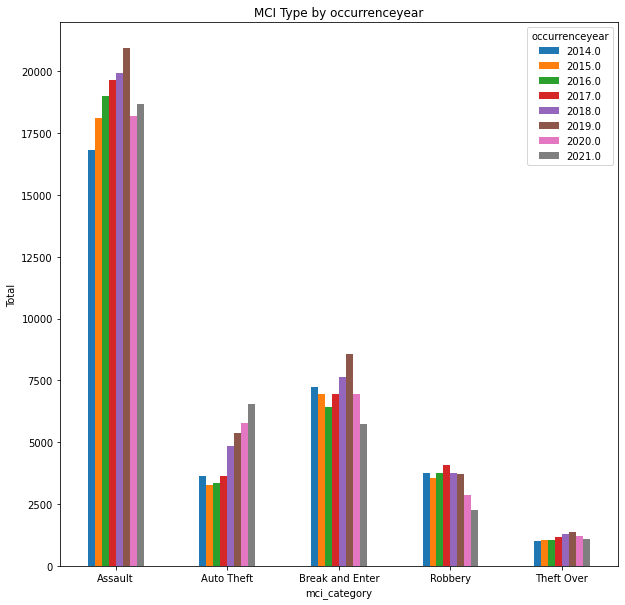

In [22]:
### Exploring the data to gain insigths
### Using pandas crosstab // Feb 24, 2023
data_ct_plot = pd.crosstab(data.mci_category, data.occurrenceyear)
data_ct_plot.plot(kind='bar', stacked=False, rot = 0, figsize=(10, 10));
plt.ylabel('Total')
plt.title('MCI Type by occurrenceyear')

In [23]:
### Exploring the data to gain insigths
### Describe from data_crosstable // Feb 27,2023
data_ct[0:-1].describe()

occurrenceyear,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,All
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000
mean,6493.400000,6584.000000,6721.600000,7100.200000,7488.000000,7993.400000,6994.600000,6855.400000,56230.60000
std,6180.772872,6788.665627,7130.768353,7296.413174,7315.043335,7693.356439,6655.983308,6989.840649,55786.33751
min,1014.000000,1043.000000,1042.000000,1186.000000,1285.000000,1369.000000,1209.000000,1068.000000,9216.00000
25%,3645.000000,3265.000000,3346.000000,3654.000000,3755.000000,3723.000000,2858.000000,2280.000000,27786.00000
50%,3757.000000,3545.000000,3776.000000,4092.000000,4829.000000,5369.000000,5766.000000,5717.000000,36415.00000
75%,7231.000000,6939.000000,6435.000000,6938.000000,7652.000000,8574.000000,6960.000000,6541.000000,56446.00000
max,16820.000000,18128.000000,19009.000000,19631.000000,19919.000000,20932.000000,18180.000000,18671.000000,151290.00000


In [24]:
### Exploring the data to gain insigths / Kurtosis from data_crosstable // Feb 27,2023
### Is a measure of the "tailedness" of the probability distribution of a real-valued random variable. Like skewness, kurtosis describes a particular aspect of a probability distribution. There are different ways to quantify kurtosis for a theoretical distribution, and there are corresponding ways of estimating it using a sample from a population. Different measures of kurtosis may have different interpretations.
### https://en.wikipedia.org/wiki/Kurtosis
data_ct[0:-1].kurtosis()

occurrenceyear
2014.0    2.616964
2015.0    3.128368
2016.0    3.622837
2017.0    3.511858
2018.0    3.177697
2019.0    2.822654
2020.0    2.870890
2021.0    3.024026
All       3.273454
dtype: float64

In [25]:
### Exploring the data to gain insigths
### Latitue and Longitude int(values) => 43 / -79 // a couple of ZEROS
data[['Latitude','Longitude']]

,Latitude,Longitude
0,43.766371,-79.504475
1,43.814861,-79.217083
2,43.589085,-79.534957
3,43.703212,-79.346588
4,43.645247,-79.531916
...,...,...
301181,43.717185,-79.372779
301183,43.712045,-79.280963
301193,43.710613,-79.482170
301201,43.706719,-79.245055


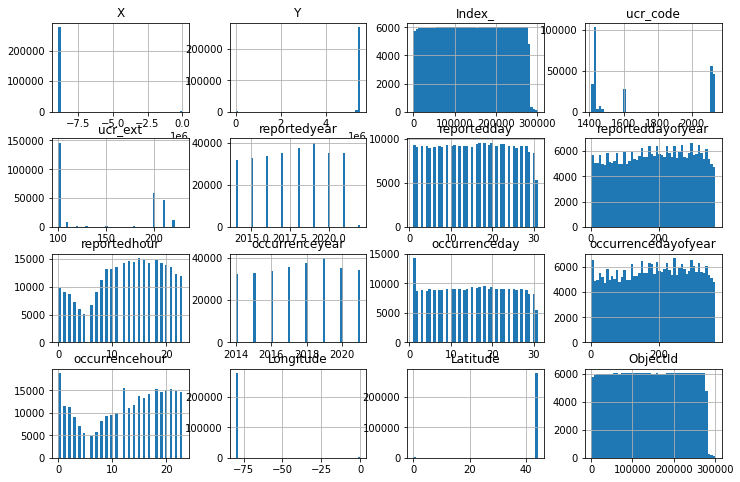

In [26]:
### Exploring the data to gain insigths / Histogram for each numerical atribute
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(12,8))
plt.show()

occurrenceyear
2014.0    16820
2015.0    18128
2016.0    19009
2017.0    19631
2018.0    19919
2019.0    20932
2020.0    18180
2021.0    18671
Name: Assault, dtype: int64


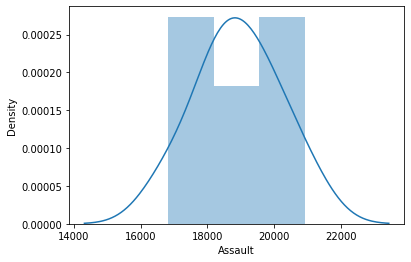

occurrenceyear
2014.0    3645
2015.0    3265
2016.0    3346
2017.0    3654
2018.0    4829
2019.0    5369
2020.0    5766
2021.0    6541
Name: Auto Theft, dtype: int64


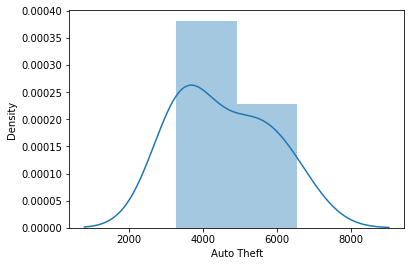

occurrenceyear
2014.0    7231
2015.0    6939
2016.0    6435
2017.0    6938
2018.0    7652
2019.0    8574
2020.0    6960
2021.0    5717
Name: Break and Enter, dtype: int64


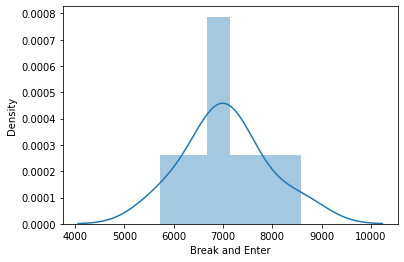

occurrenceyear
2014.0    3757
2015.0    3545
2016.0    3776
2017.0    4092
2018.0    3755
2019.0    3723
2020.0    2858
2021.0    2280
Name: Robbery, dtype: int64


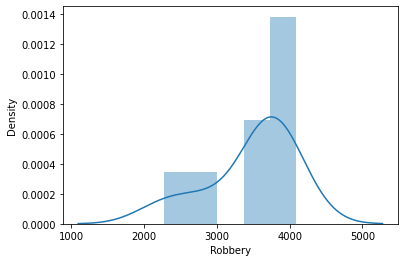

occurrenceyear
2014.0    1014
2015.0    1043
2016.0    1042
2017.0    1186
2018.0    1285
2019.0    1369
2020.0    1209
2021.0    1068
Name: Theft Over, dtype: int64


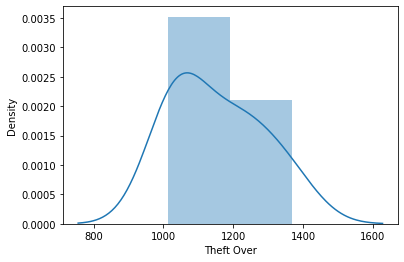

occurrenceyear
2014.0    32467
2015.0    32920
2016.0    33608
2017.0    35501
2018.0    37440
2019.0    39967
2020.0    34973
2021.0    34277
Name: All, dtype: int64


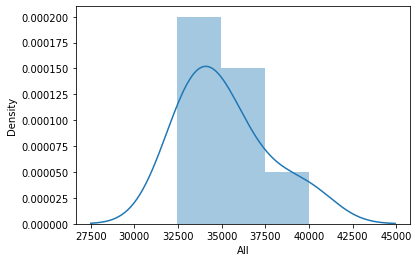

In [27]:
### Exploring the data to gain insigths
### Kurtosis from data_crosstable // Feb 27,2023
for i in range(0, data_ct.shape[0]):
    print (data_ct.iloc[i, 0:-1])
    sns.distplot(data_ct.iloc[i, 0:-1])
    #data_ct.iloc[i, 0:-1].hist(bins=5)
    plt.show()

## 3.1 MCI Category

In [28]:
### Exploring the data to gain insigths // MCI CATEGORY
### Trying to find data correlation / crosstab // Feb 24, 2023
data_ct_t =  pd.crosstab(data.mci_category, data.occurrenceyear, margins=False).reindex()
data_ct_t = data_ct_t.T
type_corr = data_ct_t.corr()
type_corr

mci_category,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
mci_category,,,,,
Assault,1.000000,0.244606,0.490954,0.254943,0.812005
Auto Theft,0.244606,1.000000,-0.072129,-0.785894,0.424078
Break and Enter,0.490954,-0.072129,1.000000,0.566080,0.743348
Robbery,0.254943,-0.785894,0.566080,1.000000,0.178567
Theft Over,0.812005,0.424078,0.743348,0.178567,1.000000


(5.5, -0.5)

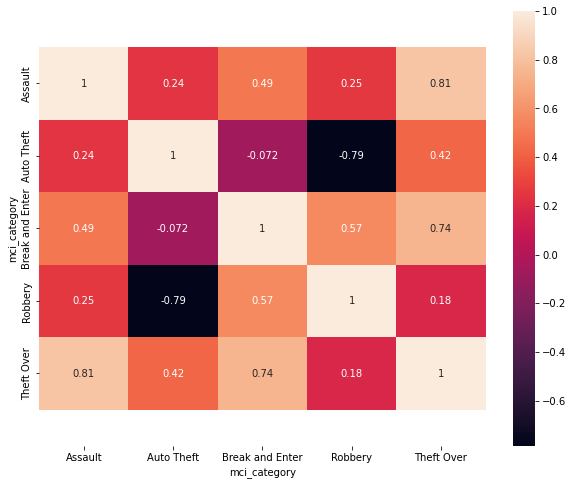

In [29]:
### Exploring the data to gain insigths
### Trying to find data correlation using sns seaborn // Feb 24, 2023
plt.figure(figsize=(10,8))
ax = sns.heatmap(type_corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Correlations: Only >=0.5

1.   **Assault** has high correlation with **Theft Over** 
2. **Auto Theft** has high correlation with **NONE**
3. **Break and Enter** has correlation with **Roberry** and **Theft Over** 
4. **Robbery** has high correlation with **Break and Enter**
5. **Theft Over** has high correlation with **Assault** and **Break and Enter**

In [30]:
### Exploring the data to gain insigths / MCI per year analysis // March 7, 2023
mciYear = data_ct.loc['All']
df_ct = data_ct.iloc[:-1,:]
mciYear = mciYear[:-1]
mciYear

occurrenceyear
2014.0    32467
2015.0    32920
2016.0    33608
2017.0    35501
2018.0    37440
2019.0    39967
2020.0    34973
2021.0    34277
Name: All, dtype: int64

In [31]:
### Exploring the data to gain insigths / MCI per year analysis // March 7, 2023
data_annual = pd.concat([pd.Series(mciYear.index, name='Year'), 
                       pd.Series(mciYear.values, name='Type')], axis=1).reset_index()
data_annual = data_annual.drop(columns=['index'])
data_annual

,Year,Type
0,2014.0,32467
1,2015.0,32920
2,2016.0,33608
3,2017.0,35501
4,2018.0,37440
5,2019.0,39967
6,2020.0,34973
7,2021.0,34277


Text(0.5, 1.0, 'Annual Total MCI')

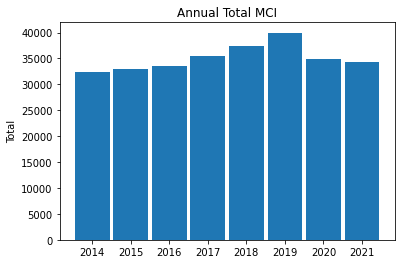

In [32]:
### Exploring the data to gain insigths / MCI per year analysis / Annual Total MCI Bar graph // March 7, 2023
plt.bar('Year', height='Type', width=0.9, align='center', data=data_annual)
plt.ylabel('Total')
plt.title('Annual Total MCI')

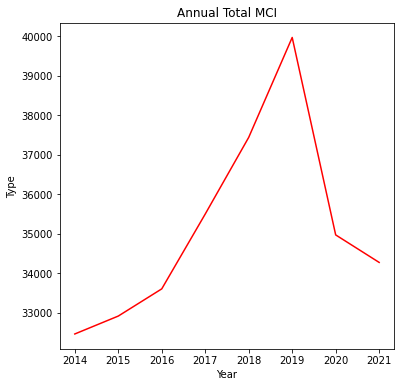

In [33]:
### Exploring the data to gain insigths / MCI per year analysis / Annual Total MCI Line graph // March 7, 2023
fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(x='Year', y='Type', data=data_annual, color='r')
ax.set_title('Annual Total MCI')
plt.show()

## 3.2 MCI by neighbourhood

In [34]:
### Exploring the data to gain insigths / MCI by neighbourhood // March 7, 2023
data_hood_ct = pd.crosstab(data.Neighbourhood, data.occurrenceyear, margins=True)
data_hood_ct.sort_values("All", axis = 0, ascending = False,
                 inplace = True) 
data_hood_ct.head(6)

occurrenceyear,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,All
Neighbourhood,,,,,,,,,
All,32467,32920,33608,35501,37440,39967,34973,34277,281153
Waterfront Communities-The Island,1035,1142,1241,1336,1466,1402,1323,1528,10473
Church-Yonge Corridor,876,896,943,1168,1319,1458,1240,1431,9331
Bay Street Corridor,784,960,949,1182,1160,1342,887,798,8062
West Humber-Clairville,887,818,876,936,1145,1014,879,941,7496
Moss Park,654,651,734,718,935,1086,1156,919,6853


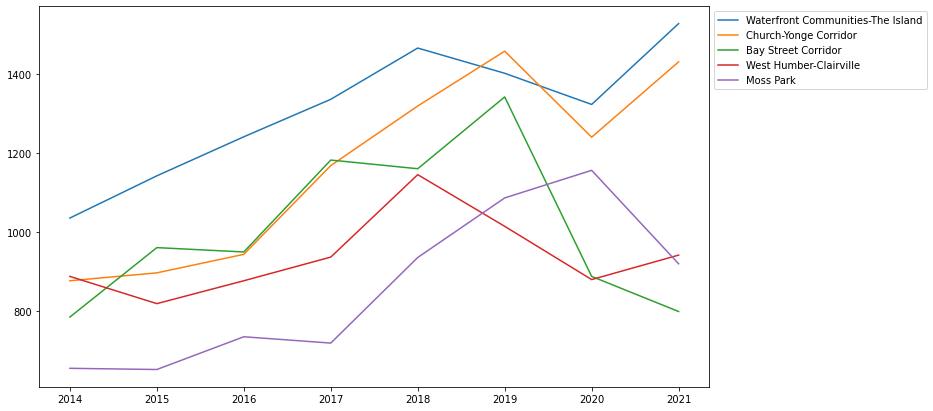

In [35]:
### Exploring the data to gain insigths / MCI by most dangerous neighbourhood // March 7, 2023
top5danger = data_hood_ct.iloc[1:6,:8].T
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(top5danger)
ax.legend(top5danger.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

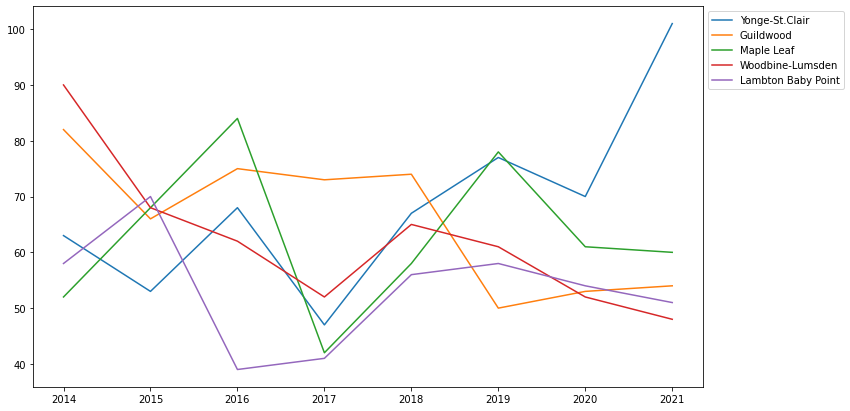

In [36]:
### Exploring the data to gain insigths 
### MCI by most dangerous neighbourhood // March 7, 2023
top5safe = data_hood_ct.iloc[-5:,:8].T
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(top5safe)
ax.legend(top5safe.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

In [37]:
### Exploring the data to gain insigths
### MCI by safest neighbourhood // March 7, 2023
data_hood_ct.tail(5)

occurrenceyear,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,All
Neighbourhood,,,,,,,,,
Yonge-St.Clair,63,53,68,47,67,77,70,101,546
Guildwood,82,66,75,73,74,50,53,54,527
Maple Leaf,52,68,84,42,58,78,61,60,503
Woodbine-Lumsden,90,68,62,52,65,61,52,48,498
Lambton Baby Point,58,70,39,41,56,58,54,51,427


## 3.3 Most dangerous hours


In [102]:
### Exploring the data to gain insigths 
### MCI by hour of the day // March 21, 2023
data_hourly_ct = pd.crosstab(data.mci_category, data.occurrencehour, margins=False)
#data_hourly_ct = pd.crosstab(data.occurrencehour, data.mci_category,margins=False)
data_hourly_ct.head()

occurrencehour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mci_category,,,,,,,,,,,,,,,,,,,,,
Assault,9830,6290,6491,4352,2773,2057,2112,2784,4257,5077,...,6898,8327,7702,7992,8320,7980,8062,7988,7545,7586
Auto Theft,2337,1217,964,800,696,617,680,913,931,984,...,1096,1163,1507,1841,2335,2345,2726,2905,3228,2898
Break and Enter,4217,2492,2571,2881,2831,2313,1617,1692,2337,2411,...,2116,2035,2047,2357,2535,2228,2033,2000,1977,2182
Robbery,1487,1429,1179,946,619,410,367,264,321,421,...,1158,1739,1570,1525,1573,1739,1914,2031,1912,1767
Theft Over,956,193,179,150,122,101,104,159,244,465,...,490,501,499,577,546,448,421,382,317,307


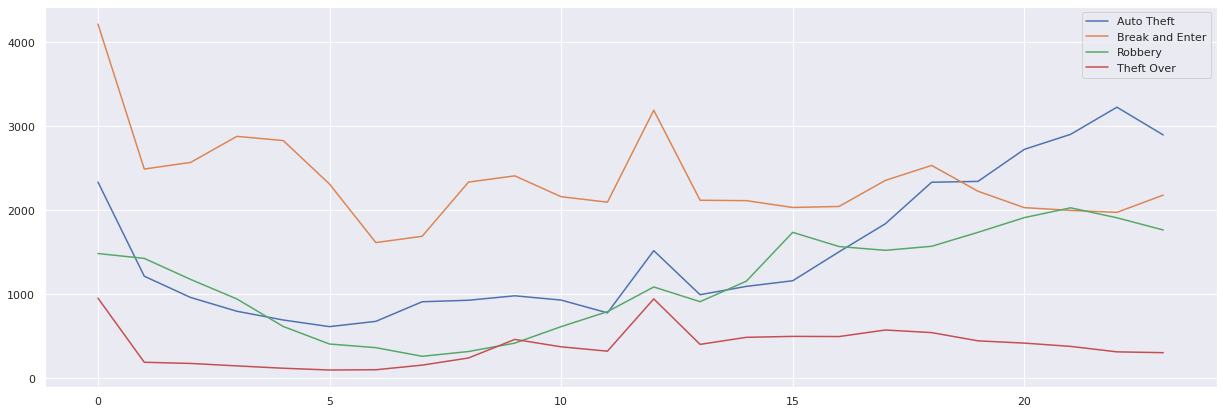

In [106]:
### Exploring the data to gain insigths 
### MCI by hour of the day // March 21, 2023
hourly_analysis = data_hourly_ct.iloc[1:23].T
fig, ax = plt.subplots(1,1,figsize=(21,7))
ax.plot(hourly_analysis)
ax.legend(hourly_analysis.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

## 3.4 Most Dangerous days of the week

In [98]:
### Exploring the data to gain insigths / MCI by day of the week // March 21, 2023
data_wdays_ct = pd.crosstab(data.mci_category, data.occurrencedayofweek, margins=False)
data_wdays_ct.head()

occurrencedayofweek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
mci_category,,,,,,,
Assault,22012,20494,23888,23738,20464,19874,20820
Auto Theft,5507,5121,4821,4782,5454,5242,5488
Break and Enter,9308,8189,7572,6990,8283,8006,8098
Robbery,4353,3842,4279,3653,3905,3846,3908
Theft Over,1558,1362,1171,1045,1373,1359,1348


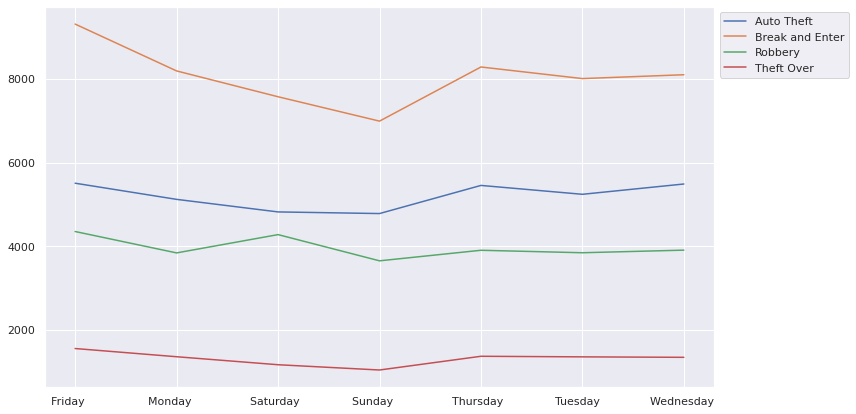

In [99]:
### Exploring the data to gain insigths / MCI by day of the week // March 21, 2023
wdays_analysis = data_wdays_ct.iloc[1:23].T
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(wdays_analysis)
ax.legend(wdays_analysis.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

## 3.5 Latitute and Longitude 

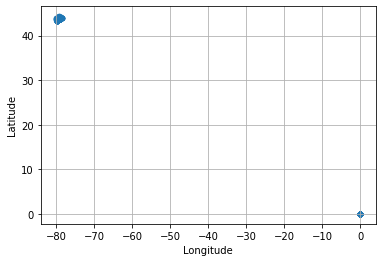

In [38]:
### Exploring the data to gain insigths / Visualizing Goegraphical Data
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [39]:
### Clean the data (68)
### Get rid of the instance / Get rid of the whole attribute / Set the missing values to some value (zero, median, mean, etc.)
### Panda's dataframe > dropna(), drop(), fillna() + Scikit-Learn SimpleImputer
### Solving the issue with Latitude and Longitude - ZERO VALUES

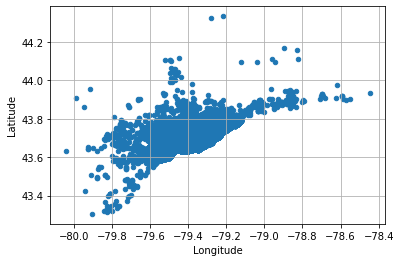

In [40]:
### Replace ZERO values for NaN = "Not a Number"
### data.replace(0, np.nan, inplace=True) ### To replace all the columns
cols = ["Latitude","Longitude"]
data[cols] = data[cols].replace(['0', 0], np.nan)
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

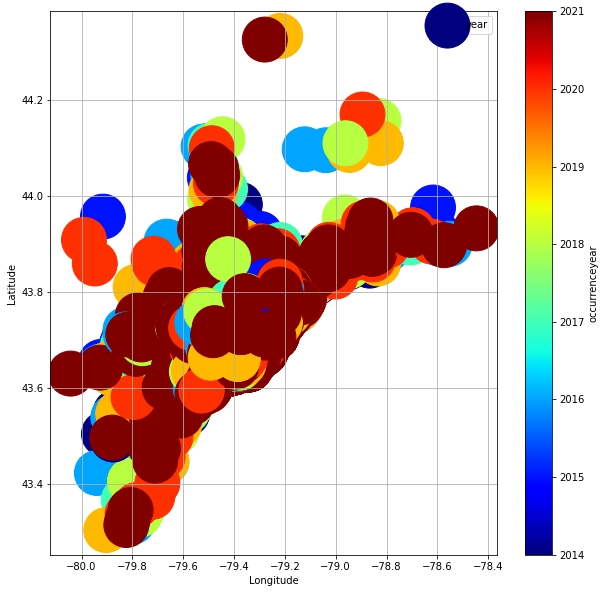

In [41]:
### Exploring the data to gain insigths / Ploting Latitude + Longitude to visualize the data
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=data["occurrenceyear"], label = "year",
          c="occurrenceyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,10))
plt.show()

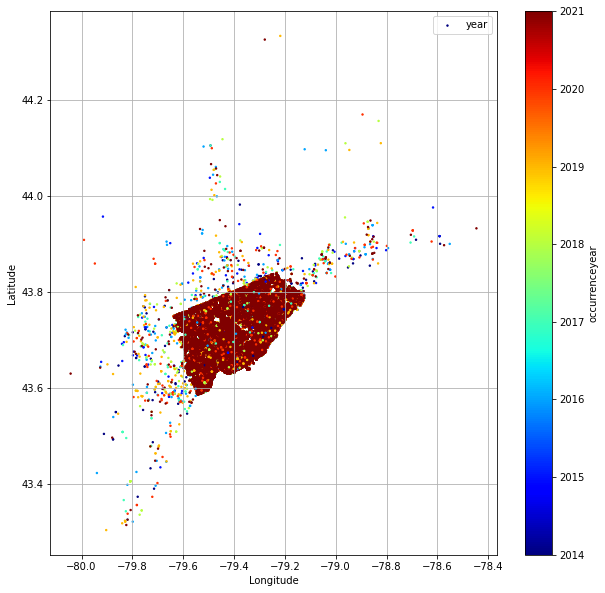

In [42]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=2, label = "year",
          c="occurrenceyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,10))
plt.show()

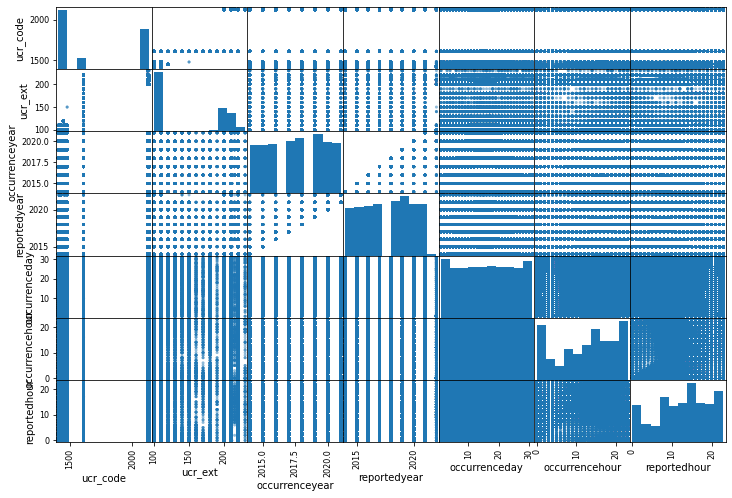

In [43]:
### Exploring the data to gain insigths / Looking for correlations - using pandas Scatter Matrix
### Scatter Matrix plots every numerical atribute against every other attribite, plus a histogram of each numerical atribute's value on the main diagonal top left to bottom rigth 
from pandas.plotting import scatter_matrix
attributes = ["ucr_code", "ucr_ext", "occurrenceyear", "reportedyear", "occurrenceday", "occurrencehour", "reportedhour"]
scatter_matrix(data[attributes], figsize=(12,8))
plt.show()

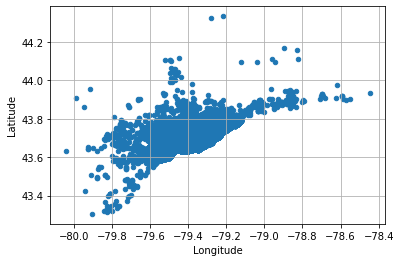

In [44]:
### Exploring the data to gain insigths
### Experiments - Attribute combinations (66)
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [45]:
### Exploring the data to gain insigths / Looking for correlations
corr_matrix = data.corr()
corr_matrix ["ucr_code"].sort_values(ascending=False)

ucr_code               1.000000
ucr_ext                0.918850
Latitude               0.040847
occurrenceyear         0.031710
Index_                 0.028218
ObjectId               0.028207
Y                      0.026724
reportedyear           0.026184
occurrencedayofyear    0.014593
occurrenceday          0.010989
reporteddayofyear      0.009899
reportedday            0.000613
X                     -0.027076
occurrencehour        -0.041334
reportedhour          -0.072141
Longitude             -0.077131
Name: ucr_code, dtype: float64

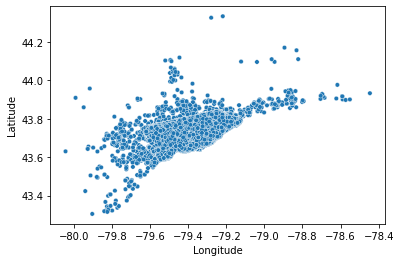

In [46]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
graph = data.loc[data.Neighbourhood == 2015]
sns.scatterplot(data=data, x="Longitude", y="Latitude", size=1, legend=False, sizes=(20, 2000))
plt.show()

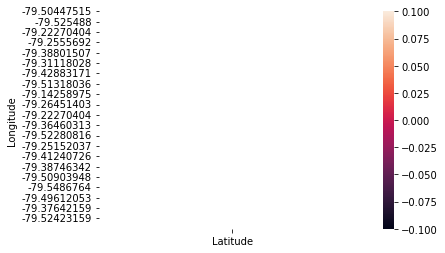

In [47]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
graph2 = pd.DataFrame(data['Latitude'], data['Longitude'])
p1 = sns.heatmap(graph2)

## 3.6 Toronto Map + Merging data
Merging data with aditional dataset
Download shape file to use for the Toronto Map // March 8, 2023
https://open.toronto.ca/dataset/neighbourhoods/
field	name / description 
FIELD_1	_id                    FIELD_2	AREA_ID           FIELD_3	AREA_ATTR_ID
FIELD_4	PARENT_AREA_ID         FIELD_5	AREA_SHORT_CODE   FIELD_6	AREA_LONG_CODE
FIELD_7	AREA_NAME              FIELD_8	AREA_DESC         FIELD_9	CLASSIFICATION
FIELD_10 CLASSIFICATION_CODE   FIELD_11 OBJECTID          geometry	geometry

In [48]:
### Tutorial -> Create a geographic heat map of the City of Toronto in Python // March 8, 2023
### https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55
!pip install geopandas
import geopandas as gpd
sns.set(style="darkgrid")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 117.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 30.3 MB/s eta 0:00:00


In [49]:
### Exploring the data to gain insigths / Group by 'Hood_ID','Neighbourhood' and count // March 8, 2023
data_gp = data.groupby(['Hood_ID','Neighbourhood']).count()[['premises_type']]
data_gp= data_gp.reset_index()
data_gp

,Hood_ID,Neighbourhood,premises_type
0,1,West Humber-Clairville,7496
1,10,Princess-Rosethorn,686
2,100,Yonge-Eglinton,1048
3,101,Forest Hill South,708
4,102,Forest Hill North,856
...,...,...,...
136,96,Casa Loma,732
137,97,Yonge-St.Clair,546
138,98,Rosedale-Moore Park,2032
139,99,Mount Pleasant East,766


In [50]:
### Exploring the data to gain insigths / Group by 'Hood_ID','Neighbourhood' and count // March 8, 2023
data['count'] = 1
dataByNeighbourhood = data.groupby('Neighbourhood').count()[['count']].reset_index()
dataByNeighbourhood['Neighbourhood'] = dataByNeighbourhood['Neighbourhood'].str.lower()
dataByNeighbourhood.sort_values('count', ascending=False).head(5)

,Neighbourhood,count
123,waterfront communities-the island,10473
23,church-yonge corridor,9331
6,bay street corridor,8062
125,west humber-clairville,7496
79,moss park,6853


In [51]:
dataByNeighbourhood.head(5)

,Neighbourhood,count
0,agincourt north,1480
1,agincourt south-malvern west,2180
2,alderwood,758
3,annex,4358
4,banbury-don mills,1552


In [52]:
### Download shape file to use for the Toronto Map // March 8, 2023
### https://open.toronto.ca/dataset/neighbourhoods/
### field	name / description 
### FIELD_1	_id                    FIELD_2	AREA_ID           FIELD_3	AREA_ATTR_ID
### FIELD_4	PARENT_AREA_ID         FIELD_5	AREA_SHORT_CODE   FIELD_6	AREA_LONG_CODE
### FIELD_7	AREA_NAME              FIELD_8	AREA_DESC         FIELD_9	CLASSIFICATION
### FIELD_10 CLASSIFICATION_CODE   FIELD_11 OBJECTID          geometry	geometry
regions = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Neighbourhoods.shp')
regions.sample(1)

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,geometry
56,57,2502310,26022825,NaN,101,101,Forest Hill South,Forest Hill South (101),Not an NIA or Emerging Neighbourhood,NaN,17825633,"POLYGON ((-79.40505 43.69598, -79.40467 43.695..."


In [53]:
regions.shape

(158, 12)

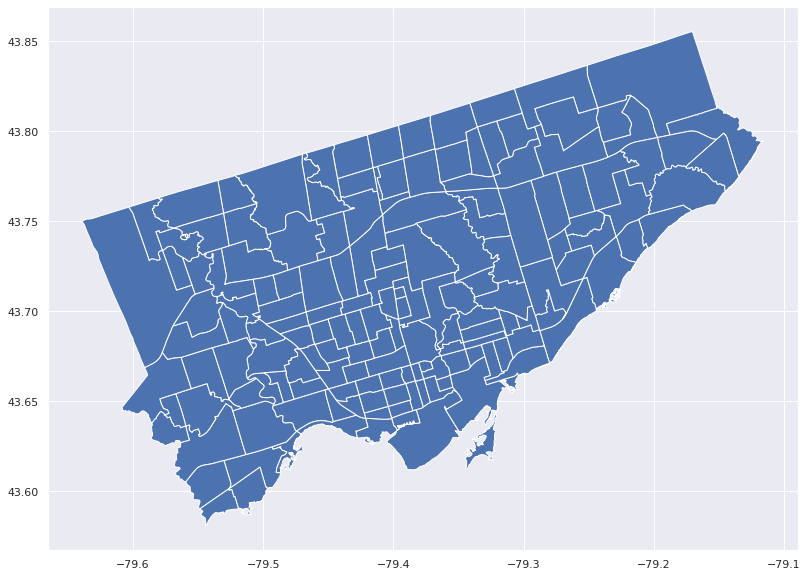

In [54]:
### Plot the data based on the downloaded shape file - Toronto Map // March 8, 2023
### https://open.toronto.ca/dataset/neighbourhoods/
regions.plot(figsize=(20,10))
plt.show()

In [55]:
regions['FIELD_7'] = regions['FIELD_7'].str.lower()
merged = regions.set_index('FIELD_7').join(dataByNeighbourhood.set_index('Neighbourhood'))
merged = merged.reset_index()
merged = merged.fillna(0)
merged[['FIELD_7', 'geometry', 'count']].sample(1)

,FIELD_7,geometry,count
153,west humber-clairville,"POLYGON ((-79.59037 43.73401, -79.58942 43.732...",7496.0


In [56]:
merged.shape

(158, 13)

In [57]:
merged.head(1)

,FIELD_7,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_8,FIELD_9,FIELD_10,FIELD_11,geometry,count
0,south eglinton-davisville,1,2502366,26022881,0.0,174,174,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,0,17824737,"POLYGON ((-79.38635 43.69783, -79.38623 43.697...",0.0


Text(0.5, 1.0, 'Heat Map of Crimes by Neighbourhood in Toronto, Ontario')

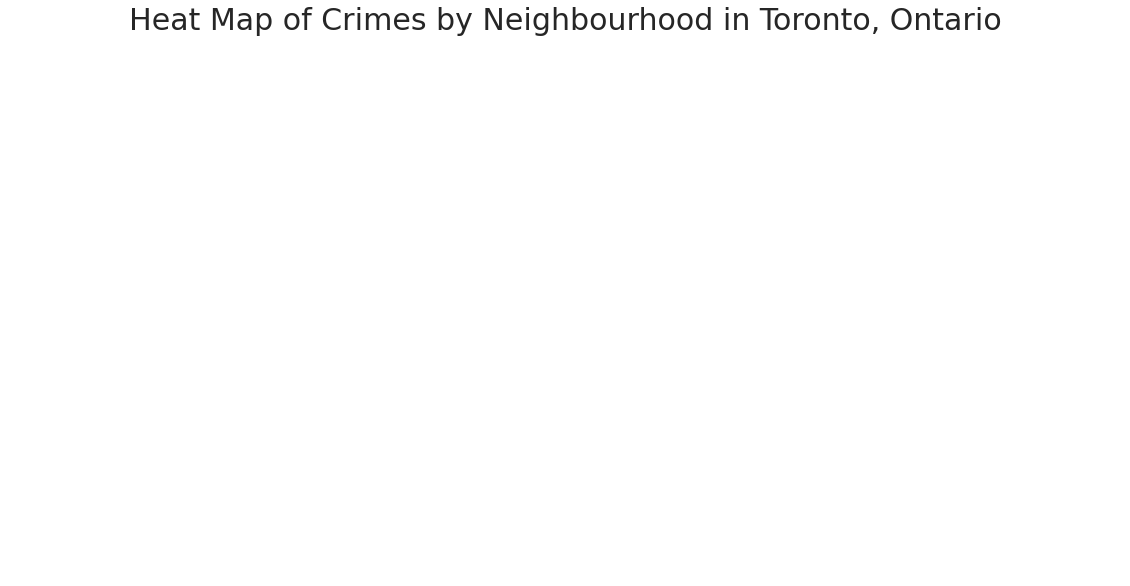

In [58]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.axis('off')
ax.set_title('Heat Map of Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '30', 'fontweight' : '3'})

<Axes: title={'center': 'Heat Map of Crimes by Neighbourhood in Toronto, Ontario'}>

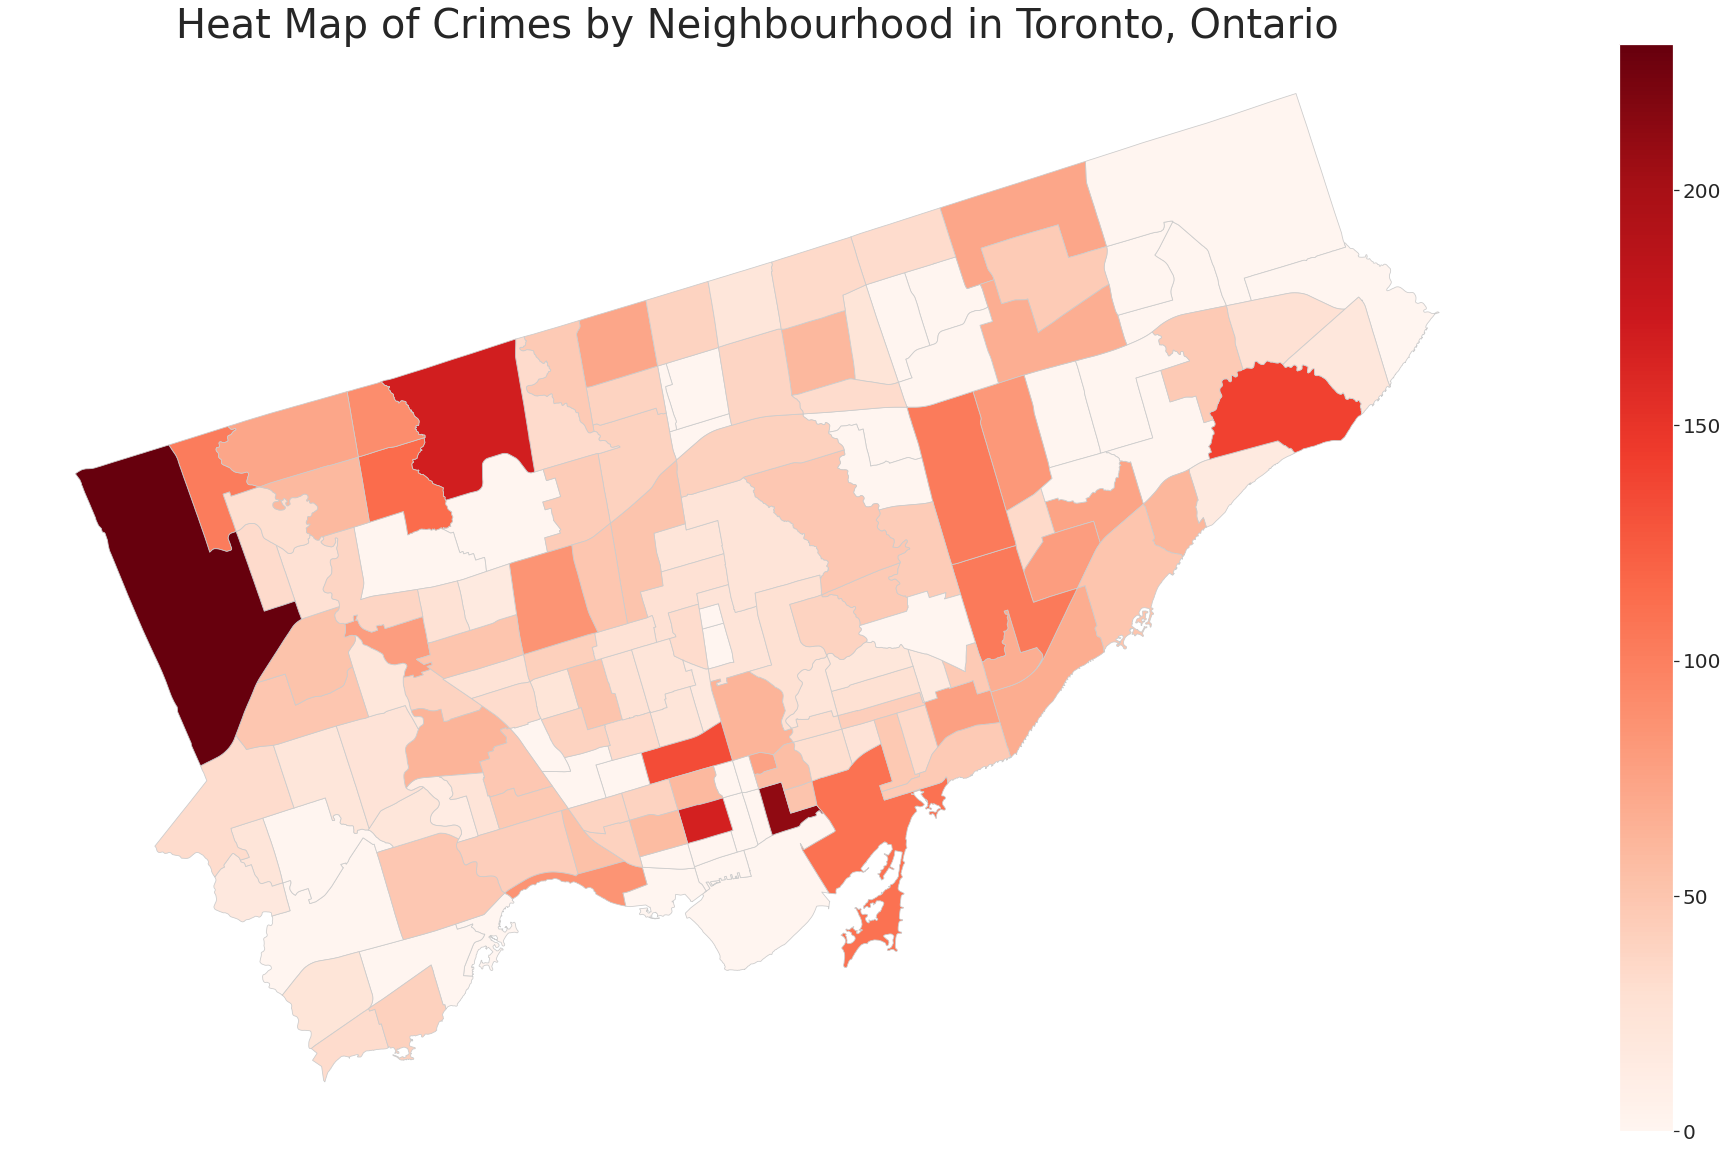

In [59]:
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'Reds'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged.plot('count', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

In [60]:
merged.head(1)

,FIELD_7,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_8,FIELD_9,FIELD_10,FIELD_11,geometry,count
0,south eglinton-davisville,1,2502366,26022881,0.0,174,174,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,0,17824737,"POLYGON ((-79.38635 43.69783, -79.38623 43.697...",0.0


In [61]:
data.describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Longitude,Latitude,ObjectId,count
count,2.811530e+05,2.811530e+05,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,277572.000000,277572.000000,281153.000000,281153.0
mean,-8.725779e+06,5.351167e+06,141581.917269,1700.832821,146.402578,2017.611799,15.747106,186.499049,12.826955,2017.578162,15.492689,186.285218,12.618443,-79.396262,43.706926,141582.294171,1.0
std,9.911719e+05,6.078589e+05,81452.615923,325.535649,51.917990,2.261671,8.767542,103.892926,6.519574,2.250533,8.904309,104.130803,7.232738,0.104750,0.053341,81453.182017,0.0
min,-8.910331e+06,0.000000e+00,2.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2014.000000,1.000000,1.000000,0.000000,-80.042866,43.304981,1.000000,1.0
25%,-8.846627e+06,5.412955e+06,71137.000000,1430.000000,100.000000,2016.000000,8.000000,98.000000,8.000000,2016.000000,8.000000,98.000000,7.000000,-79.471876,43.660816,71137.000000,1.0
50%,-8.837968e+06,5.419022e+06,141570.000000,1450.000000,100.000000,2018.000000,16.000000,189.000000,13.000000,2018.000000,16.000000,189.000000,14.000000,-79.394093,43.700476,141567.000000,1.0
75%,-8.829773e+06,5.426993e+06,212067.000000,2120.000000,200.000000,2020.000000,23.000000,276.000000,18.000000,2019.000000,23.000000,276.000000,19.000000,-79.324574,43.751664,212067.000000,1.0
max,0.000000e+00,5.517228e+06,301144.000000,2135.000000,230.000000,2022.000000,31.000000,366.000000,23.000000,2021.000000,31.000000,366.000000,23.000000,-78.446267,44.333691,301206.000000,1.0


In [62]:
data.head()

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId,count
0,-8.850398e+06,5.429359e+06,201,GO-20141273318,D31,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Apartment (Rooming House, Condo)",Apartment,1430,...,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371,1,1
1,-8.818405e+06,5.436836e+06,202,GO-20141274349,D42,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,...,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861,2,1
2,-8.853791e+06,5.402071e+06,203,GO-20141274052,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,...,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085,3,1
3,-8.832822e+06,5.419628e+06,204,GO-20141276966,D53,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,...,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212,4,1
4,-8.853452e+06,5.410706e+06,205,GO-20141274457,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Convenience Stores,Commercial,1610,...,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247,5,1


In [63]:
### Plot the data based on the downloaded shape file - Toronto Map // March 16, 2023
### https://www.jiristodulka.com/post/toronto-crime/
###
import folium #maping crime on the map
from folium.plugins import HeatMap, MarkerCluster #making maping visually appealing
### Top N Criminal Neighbourhoods in Toronto 
top_N = data.groupby('Neighbourhood')[['mci_category']].count().sort_values(by=['mci_category'])
### Coordinates Criminal Neighbourhoods
map_data = data[['Neighbourhood', 'Latitude', 'Longitude']].drop_duplicates('Neighbourhood').set_index('Neighbourhood') \
    .join(top_N, how='inner')
map_data.sort_values(by=['mci_category'], ascending=False).head(10)

,Latitude,Longitude,mci_category
Neighbourhood,,,
Waterfront Communities-The Island,43.649131,-79.390756,10473
Church-Yonge Corridor,43.648627,-79.373824,9331
Bay Street Corridor,43.650868,-79.382626,8062
West Humber-Clairville,43.697108,-79.586443,7496
Moss Park,43.653729,-79.373215,6853
York University Heights,43.766371,-79.504475,5468
Kensington-Chinatown,43.653346,-79.396125,5396
Downsview-Roding-CFB,43.719831,-79.513761,5344
Woburn,43.773498,-79.230640,4989


In [64]:
x=data
map_data = map_data.dropna()

In [65]:
### Plot the data based on the downloaded shape file - Toronto Map // March 16, 2023
### https://www.jiristodulka.com/post/toronto-crime/
###
m = folium.Map(
    location=[43.702270, -79.366074],
    zoom_start=11
)
###Step 1: Clusters
cluster = MarkerCluster().add_to(m)
###Step 2: Clusters breaking into Markers
for x in map_data.iterrows():
    folium.Marker([x[1].Latitude, x[1].Longitude]).add_to(cluster)
###Step 3: Heat
max_crime = map_data['mci_category'].max() # max value as reference for the darkets shade
heat = HeatMap(map_data.values,
                min_opacity=0.2,
                max_val=max_crime,
                radius=30, blur=20, 
                max_zoom=11)
heat.add_to(m)
m # call m to see the heat map with clusters

## 3.7 Correlations

In [66]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
import plotly.express as px
import xarray as xr
# Load xarray from dataset included in the xarray tutorial
airtemps = xr.tutorial.open_dataset('air_temperature').air.sel(lon=250.0)
fig = px.imshow(airtemps.T, color_continuous_scale='RdBu_r', origin='lower')
fig.show()

In [67]:
### Adding a new attribute qtd of days since reported first time - using current date
### date.today() / datetime.now()
### time.struct_time((d.year, d.month, d.day, 0, 0, 0, d.weekday(), yday, -1))
### https://docs.python.org/3/library/datetime.html
### class datetime.datetime(year, month, day, hour=0, minute=0, second=0, microsecond=0, tzinfo=None, *, fold=0)

from datetime import date
from datetime import datetime
today_date_iso = (datetime.today())
data['reporteddate'] = pd.to_datetime(data['reporteddate'])
#data['days_since_reported'] = today_date_iso - datetime(data['reporteddate'], tzinfo=None).isoformat() 

#(pd.to_datetime(data['reporteddate']))
#data['reporteddate'] = datetime(data['reporteddate']).isoformat()
#data["days_since_reported"] = (datetime(2023, 2, 23, tzinfo=None).isoformat()) - (datetime(data['reporteddate'], tzinfo=None).isoformat())

#today = today.replace(tzinfo=None)


In [68]:
dia = datetime.now(tz=None).isoformat()
dia

'2023-03-21T12:52:22.878346'

In [69]:
print (datetime(2023, 2, 23, tzinfo=None).isoformat())
#current date format -> 2014/01/03 05:00:00+00

2023-02-23T00:00:00


# 4 - Prepare the data for ML algorithm


In [70]:
### Preparimg the data for the ML algorith // March 8, 2023
###

# 5 - Select a Model and Train it

6 - Fine-tuning the model 

# 6 - Fine-tunig the model

# Results and Model Performance 